In [39]:
import numpy as np
import math
import sympy as sym
from scipy.integrate import ode
from scipy.io import loadmat
import scipy.io
import scipy
from scipy import stats
import pickle
import copy
import filter_functions
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

#define constants
r_earth_const = 6378136.3 * 1e-3 #km
omega_const = 7.2921158553e-5 #rad/s, angular velocity of earth
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 * 1e-9 #km^3/s^2


#Drag:
A_const = 0.9551567 * 1e-6 #km^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite
C_D_const = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec

In [40]:

num_of_X_ensembles = 450

meas_type = 3

if meas_type == 1:
    meas_file = open('Data Files/meas_range_rangeRate.pkl', 'rb')
elif meas_type == 2:
    meas_file = open('Data Files/meas_az_el.pkl', 'rb')
elif meas_type == 3:
    meas_file = open('Data Files/meas_az_el_range_90RAAN.pkl', 'rb') #_10s_all_3stat.pkl
    
    
    
#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year_init = 2017
month_init = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init + boulder_UT_offset
    
    

#Canbera Station (DSS 34)
lat_dss34 = math.radians(-35.398333)
lon_dss34 = math.radians(148.981944)
alt_dss34 = 691.75 * 1e-3 #km

r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
#print(r_ecef_dss34)

#Madrid Station (DSS 65) -- correct position of Madrid Station
lat_dss65 = math.radians(40.427222)
lon_dss65 = math.radians(355.749444)
alt_dss65 = 834.539 * 1e-3 #km

r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
#print(r_ecef_dss65)

#Goldstone Station (DSS 13) 
lat_dss13 = math.radians(35.247164)
lon_dss13 = math.radians(200.205)
alt_dss13 = 1071.14904 * 1e-3 #km

r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
#print(r_ecef_dss13)

#Diego Garcia, British Indian Ocean Territory 7.41173°S 72.45222°E., Space Fence (Dedicated Sensor
lat_diego = math.radians(-7.41173)
lon_diego = math.radians(72.45222)
alt_diego = 0 * 1e-3 #km, "sea level"

r_ecef_diego = filter_functions.topo2ecef(lat_diego, lon_diego, alt_diego, r_earth_const)




# read python dict containing measurements
mydict2 = pickle.load(meas_file)
meas_file.close()
measurement_array = mydict2['measurement_array']
truth_xyz = mydict2['truth_pos_vel']
true_density_array = mydict2['true_density']*1e9
lat_lst_meas_array = mydict2['lat_lst_array']
print(np.shape(measurement_array))
print(np.shape(truth_xyz))

#convert to km
truth_xyz = truth_xyz * 1e-3
measurement_array[:, -1] = measurement_array[:, -1] * 1e-3
print(measurement_array[200,0]/(60))
print(measurement_array[150,0]/(60)/90)



#sample measurements so only using every nth measurement
"""
truth_xyz = truth_xyz[0::20]
measurement_array = measurement_array[0::20]
true_density_array = true_density_array[0::20]
lat_lst_meas_array = lat_lst_meas_array[0::20]
print(measurement_array[50,0]/(60))
"""



(407, 5)
(407, 6)
784.0
7.9


'\ntruth_xyz = truth_xyz[0::20]\nmeasurement_array = measurement_array[0::20]\ntrue_density_array = true_density_array[0::20]\nlat_lst_meas_array = lat_lst_meas_array[0::20]\nprint(measurement_array[50,0]/(60))\n'

In [41]:
#read in files necessary for ensemble & density est. portion


# read python dict containing densities
ensemble_file = open('Data Files/ensemble_density_grids.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of Vector of State/density Ensembles:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

#convert from kg/m**3 to kg/km**3 -> 1/(1e-3)**3 = 1/(1e-9) = 1e9
ensembles_of_density_grid = ensembles_of_density_grid * 1e9

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"



#add noise w/ standard deviation = 1e-4 (used as initialization of density covariance, as well)

print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles)
ensemble_noise = np.random.randn(num_of_ensembles, num_of_lat, num_of_lon) * 1e-4#1e-9 #1e-4****
ensembles_of_density_grid = ensembles_of_density_grid + ensemble_noise
print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles) 


Shape of Vector of State/density Ensembles: (450, 37, 73)
0.000479211906198
0.00048079533544


In [42]:

#Propogate reference trajectory and S.T.M.
def orbitpropogator_EnKF(t, X_vector, density):
    
    ensemble_member = X_vector

    #find X acceleration via the F(X) lambdified equation
    state_acc = X_dot_sol_fcn(ensemble_member[0], ensemble_member[1], ensemble_member[2], \
                                  ensemble_member[3], ensemble_member[4], ensemble_member[5], density)
        
    dx = state_acc.flatten()
    return dx


In [43]:

#EnKF specific functionality




def gen_ensemble(X_0, Bsqrt_cov, ensemble_size):
    
    X_0 = X_0.reshape(len(X_0), 1)
    
    ensemble = np.zeros((len(X_0), ensemble_size))
    
    for ii in range(ensemble_size):
        
        member = X_0 + np.dot(Bsqrt_cov, np.random.randn(len(X_0), 1))

        ensemble[:, ii] = member.reshape(len(X_0))
    
    return ensemble
    



In [44]:
#two body motion force
# **Setup force equations/acceleration/U

#Force equations with J_2
x, y, z, J_2, r_earth, mu, r, J_3 = sym.symbols('x y z J_2 r_earth mu r J_3')


two_body_J2_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )' #potential
two_body_J2 = sym.sympify(two_body_J2_string)
two_body_J2 = two_body_J2.subs([(r, sym.sqrt(x**2+y**2+z**2))])
two_body_J2_acc_x = two_body_J2.diff(x)
two_body_J2_acc_y = two_body_J2.diff(y)
two_body_J2_acc_z = two_body_J2.diff(z)


two_body_J2_acc_x = two_body_J2_acc_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_y = two_body_J2_acc_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_z = two_body_J2_acc_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
#print('2 body & J2', two_body_J2_acc_x)

x_acc = two_body_J2_acc_x
y_acc = two_body_J2_acc_y
z_acc = two_body_J2_acc_z

In [45]:
#Add drag to J_2 force equations

x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot = \
    sym.symbols('x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot')
    
C_D, A, m, density, theta_dot, val, val_dot = \
    sym.symbols('C_D A m density theta_dot val, val_dot')

drag_str = ('-(1/2)*C_D*(A/m)*density*'
                'sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +'
                'z_dot**2)*(val_dot+theta_dot*val)')
drag_symp = sym.sympify(drag_str)

drag_symp = drag_symp.subs([(A, A_const), (m, m_const), (C_D, C_D_const),\
                        (theta_dot, theta_dot_const)])


x_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, y), (val_dot, x_dot)])
x_acc = x_acc + x_drag_symp

y_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, x), (val_dot, y_dot)])
y_acc = y_acc + y_drag_symp

z_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, z), (val_dot, z_dot)])
z_acc = z_acc + z_drag_symp
    


x_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)

In [46]:


if (meas_type == 1) or (meas_type == 3):
    
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

    #define symbolic rho equation
    rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
    rho = sym.sympify(rho)
    #sub rotation equation of ecef for eci
    rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
    rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
    rho = rho.subs(z_s, z_sf)

    #define symbolic rho dot equation
    rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
               theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
               theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
    rho_dot = sym.sympify(rho_dot)
    #execute substitutions for rho_dot
    rho_dot = rho_dot.subs(x_s, x_sf) 
    rho_dot = rho_dot.subs(y_s, y_sf) 
    rho_dot = rho_dot.subs(z_s, z_sf) 
    rho_dot = rho_dot.subs('rho', rho)
    rho_dot = rho_dot.subs(theta, omega_const*t)    
    rho_dot = rho_dot.subs(theta_dot, omega_const)

    rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
    rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)


if (meas_type == 2) or (meas_type == 3):
    
    #x_sf, etc. is the sensor pos in ecef
    #x, y, z is the satellite eci
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
    x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
        sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')
        

    #define symbolic rho equation
    azimuth = ('atan2(x_L, y_L)') #step 4
    azimuth = sym.sympify(azimuth)
    
    elevation = ('asin(z_L/X_L_norm)') #step 4
    elevation = sym.sympify(elevation)
    elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))
    
    #step 3
    azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
    elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
            (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])
    
    #step 2
    azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    
    #step 1
    azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    
    
    azimuth = azimuth.subs([(theta, omega_const*t), (omega, omega_const)])
    elevation = elevation.subs([(theta, omega_const*t), (omega, omega_const)])
    
    azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
    elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)
    



In [47]:
#State and A matrix


#define the symbolic state matrix
X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot])
X_dot = sym.Matrix([x_dot, y_dot, z_dot, x_acc, y_acc, z_acc])
    

#partial of the force model (x dot) WRT the state vector
A_mat = X_dot.jacobian(X)
#print(A_mat)

A_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), A_mat)
#print(A_sol_fcn(1,2,3,4,5,6,7,8))

#print(X_dot)
X_dot_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), X_dot)

In [48]:
#define observation model (G) and H_tilde


if meas_type == 1:
    G = sym.Matrix([rho, rho_dot])
    
    
elif meas_type == 2:
    G = sym.Matrix([azimuth, elevation])
    
elif meas_type == 3:
    G = sym.Matrix([azimuth, elevation, rho])

#print(G)
G_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), G)

#partial derivitive of observation model WRT the state vector
X_full = X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot, density])
H_tilde = G.jacobian(X_full)
#print(H_tilde)
H_tilde_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), H_tilde)

In [49]:



def calc_P_TU(X_mean, ensemble):
    
    dimension = len(X_mean)
    
    P_bar_sum = np.zeros((dimension, dimension))
    
    for ii in range(num_of_X_ensembles):

        X = ensemble[:, ii].reshape(dimension, 1)
        diff_X = X - X_mean
        P_bar_sum = P_bar_sum + np.dot(diff_X, diff_X.T)

    P_bar = P_bar_sum/(num_of_X_ensembles-1)

    return P_bar



In [50]:
#define reference state at epoch, covariance at epoch, and R (using measurement noise)

pos_perturbation = 100 * 1e-3 #km
vel_perturbation = .1 * 1e-3 #km/s

density_dimension = num_of_lat * num_of_lon
prob_dimension = 6
fullState_dimension = prob_dimension + density_dimension

X_ref = np.array([truth_xyz[0,0] + pos_perturbation, truth_xyz[0,1] + pos_perturbation, truth_xyz[0,2] \
            + pos_perturbation, truth_xyz[0,3] + vel_perturbation, truth_xyz[0,4] + vel_perturbation, \
            truth_xyz[0,5] + vel_perturbation])

                  
P_sigma_pos = 100 * 1e-3 #km
P_sigma_vel = .1 * 1e-3 #km/s
P_bar_0 = np.diag([P_sigma_pos**2, P_sigma_pos**2, P_sigma_pos**2, \
                   P_sigma_vel**2, P_sigma_vel**2, P_sigma_vel**2, (1e-4)**2]) #(1e-4)**2


(L, V) = np.linalg.eig(P_bar_0[:prob_dimension, :prob_dimension]) #eigenvalues, eigenvectors
Bsqrt_cov = V * np.sqrt(L)
X_ensemble = gen_ensemble(X_ref, Bsqrt_cov, num_of_X_ensembles)
print(np.shape(X_ensemble))

       
                  
#Define Measurement Noise
if meas_type == 1:
    sigma_rho = .1 * 1e-3 #km
    sigma_rho_dot = .01 * 1e-3 #km/s
    W = np.array([[1/sigma_rho**2, 0], [0, 1/sigma_rho_dot**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 2:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    W = np.array([[1/sigma_az**2, 0], [0, 1/sigma_el**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 3:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    sigma_rho = .1 * 1e-3 #km
    W = np.array([[1/sigma_az**2, 0, 0], [0, 1/sigma_el**2, 0], [0, 0, 1/sigma_rho**2]])
    R = np.linalg.inv(W)
    
    meas_indices = np.array([0, 1, 2])

    

    
print(X_ref)

(6, 450)
[  7.950796762291823e+02   6.701934506850498e+03  -6.279746517887071e+02
  -5.805111155451634e+00   1.147516427146103e+00   4.877657130745605e+00]


In [51]:
#KALMAN

def execute_enkf(obs_data, X_ensemble, P, R, density_state_ensemble,\
                         prob_dimension, density_dimension, stop_index):
    
    #initializations
    Q_ECI = np.zeros((6,6))
    
    num_of_meas = np.shape(R)[0]
    X_mean_updated = np.sum(X_ensemble, axis=1)/num_of_X_ensembles

    post_fit_list = np.zeros((stop_index, num_of_meas))

    P_list = np.zeros((stop_index, prob_dimension+1, prob_dimension+1))
    X_mean_updated_list = np.zeros((stop_index, prob_dimension+1))
    
    density_MSIS_array = np.zeros(stop_index)
    est_density_array = np.zeros(stop_index)
    #est_density_grid_array = np.zeros((stop_index, num_of_lat, num_of_lon))

    
    X_distribution = np.zeros((prob_dimension, num_of_X_ensembles, stop_index))
    density_distribution = np.zeros((num_of_ensembles, stop_index))
    lat_lst_array = np.zeros((2, stop_index))
    X_density_ensemble = np.zeros((fullState_dimension, num_of_X_ensembles))

    

    for obsnum in range(len(obs_data[:stop_index])):
        
        print(obsnum, obs_data[obsnum, 0])
        
        
        time = obs_data[obsnum, 0]
        t_init = obs_data[obsnum-1, 0] 
        if obsnum == 0:
            t_init = obs_data[obsnum, 0]
            
        #save true MSIS density for this time step (which is density at beginning of time used to prop for this step)
        density_MSIS = filter_functions.calc_MSIS_density(time, X_mean_updated, day_of_year_init, day_of_month_init, \
                                                hour_init_UT, month_init, year_init, omega_const, r_earth_const)
        density_MSIS = density_MSIS * 1e9  #convert from kg/m**3 to kg/km**3
        density_MSIS_array[obsnum] = density_MSIS
        
        
        #determine density to be used in propagation
        (lat_grid_ticks, lst_grid_ticks) = filter_functions.calc_lat_lst_indices(t_init, \
                            X_mean_updated[:3].reshape(3,1), day_of_month_init, hour_init_UT, month_init, \
                                   year_init, omega_const, r_earth_const, lat_res, lon_res)
        
        latt = np.degrees(latitude_grid[lat_grid_ticks])
        lonn = np.degrees(longitude_grid[lst_grid_ticks])
        
        lat_meas = lat_lst_meas_array[obsnum-1, 0]
        lon_meas = lat_lst_meas_array[obsnum-1, 1]
        
        densities = density_state_ensemble[:, lat_grid_ticks, lst_grid_ticks]


        result = X_ensemble

        if (obs_data[obsnum, 0] != obs_data[obsnum-1, 0]) and (obsnum != 0):
            
            result = np.zeros((prob_dimension, num_of_X_ensembles))

            for ii in range(num_of_X_ensembles):
                #set the initial values for the propogator:
                y0 = X_ensemble[:, ii]
                density = densities[ii]
            
                integrator = ode(orbitpropogator_EnKF)
                integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
                integrator.set_f_params(density)
                integrator.set_initial_value(y0, t_init)
                integrator.integrate(time)
                result[:, ii] = integrator.y

        X_ensemble = result.reshape(prob_dimension, num_of_X_ensembles)
        
        
        #create array that holds X state ensemble & density state ensemble combined
        density_state = density_state_ensemble[:, lat_grid_ticks, lst_grid_ticks]
        X_density_ensemble[:6, :] = X_ensemble
        X_density_ensemble[6:, :] = density_state_ensemble.reshape(num_of_ensembles, density_dimension).T 
        #****density_state
        
        #mean of X state & density state over ensemble
        X_bar = np.sum(X_density_ensemble, axis=1).reshape(fullState_dimension,1)/num_of_X_ensembles
        
        #calculate Time Updated P
        P_TU = calc_P_TU(X_bar, X_density_ensemble)
        
        
        E = X_density_ensemble - np.tile(X_bar, num_of_ensembles)

        
        
        #determine station coordinates for observation eq.
        if int(obs_data[obsnum, 1]) == 1:
            #print('1')
            station_index = 0
            X_s = r_ecef_dss34
        if int(obs_data[obsnum, 1]) == 2:
            #print('2')
            station_index = 1
            X_s = r_ecef_dss65
        if int(obs_data[obsnum, 1]) == 3:
            #print('3')
            station_index = 2
            X_s = r_ecef_dss13
        if int(obs_data[obsnum, 1]) == 4:
            #print('amos')
            station_index = 3
            X_s = r_ecef_diego

        
        #-------------------Measurement Update--------------------------------------------------------
        
        
        P_f = (1/(num_of_ensembles-1)) * np.dot(E, E.T)
        
        H = np.zeros((num_of_meas, fullState_dimension))
        H[:num_of_meas, :prob_dimension+1] = H_tilde_sol_fcn(*X_bar[:6,0], *X_s, time)
        
        part1 = np.dot(P_f, H.T)
        part2 = np.dot(H, np.dot(P_f, H.T))
        K = np.dot(part1, np.linalg.inv(part2 + R))
        
        
        Hx_array = np.zeros((num_of_meas, num_of_X_ensembles))
        Hx = np.zeros(3)
        for ii in range(num_of_X_ensembles):
            
            X = X_ensemble[:, ii]

            Hx = G_sol_fcn(*X, *X_s, time)
            
            if (meas_type != 1) and (Hx[0] < 0): #if az less than 0, add 2*pi
                Hx[0] = Hx[0] + 2*math.pi

            Hx_array[:, ii] = Hx.reshape(num_of_meas)
        
        
        #get actual observation
        y_observed = obs_data[obsnum, 2:(2+num_of_meas)].reshape(num_of_meas,1)
        
        
        X_density_ensemble_updated = np.zeros((fullState_dimension, num_of_X_ensembles))
        #**correction_array = np.zeros((1, num_of_X_ensembles))
        for ii in range(num_of_X_ensembles):
            
            e = np.sqrt(np.diag(R)).reshape(num_of_meas, 1) * np.random.randn(num_of_meas, 1)
            
            correction = np.dot(K, (y_observed + e - Hx_array[:, ii].reshape(num_of_meas, 1)))
            
            X_member_updated = X_density_ensemble[:, ii].reshape(fullState_dimension, 1) + correction
                
            X_density_ensemble_updated[:, ii] = X_member_updated.reshape(fullState_dimension)
        
        
        
   
    
        
        #update overall density grid ensemble with this lat/lon's updated density values 
        updated_density_portion = X_density_ensemble_updated[6:,:].T.reshape(num_of_ensembles, num_of_lat, num_of_lon)
        density_state_ensemble = copy.deepcopy(updated_density_portion) 
        #est_density_grid_array[obsnum] = np.mean(density_state_ensemble, axis=0)
        

        est_density_array[obsnum] = np.sum(updated_density_portion[:, lat_grid_ticks, lst_grid_ticks])\
                                                                                            /num_of_ensembles
            
        #save values
        X_mean_updated = np.zeros((7))
        X_mean_updated[:6] = np.sum(X_density_ensemble_updated[:6,:], axis=1)/num_of_X_ensembles
        X_mean_updated[6:] = est_density_array[obsnum]
        X_mean_updated_list[obsnum, :] = X_mean_updated
        
        #save values for analysis of distributions and such
        density_distribution[:, obsnum] = updated_density_portion[:, lat_grid_ticks, lst_grid_ticks] 
        X_distribution[:, :, obsnum] = X_density_ensemble_updated[:6, :]
        lat_lst_array[:, obsnum] = np.array([latitude_grid[lat_grid_ticks], longitude_grid[lst_grid_ticks]]).reshape(2)

        

        eigs = np.linalg.eigvals(P_f)
        indices = np.where(eigs <= 0)[0]
        print(np.shape(indices)[0])
        
        
        P_list[obsnum, :6, :6] = P_f[:6, :6]
        P_list[obsnum, -1, -1] = P_f[0,6:].reshape(num_of_lat, num_of_lon)[lat_grid_ticks, lst_grid_ticks]


        #-------------RMS / Residuals-------------
        Hx = G_sol_fcn(*X_mean_updated[:6], *X_s, time)
        if Hx[0] < 0:
            Hx[0] = Hx[0] + 2*math.pi
        post_fit_resid = y_observed - Hx.reshape(num_of_meas, 1)
        post_fit_list[obsnum, :] = post_fit_resid.reshape(num_of_meas) 
        

        #Prep for next time step
        X_ensemble = X_density_ensemble_updated[:6, :]

    
    
    return (X_mean_updated_list, P_list, post_fit_list, density_MSIS_array, est_density_array, X_distribution, \
            density_distribution, lat_lst_array, updated_density_portion, X_ensemble)#, est_density_grid_array)

In [52]:
#Call EnKF


stop_index = 150 #558 * 3 #92.56 minutes #/2

(X_mean_updated_list_EnKF, P_list_EnKF, post_fit_list_EnKF, density_MSIS_array, est_density_array,\
X_distribution, density_distribution, lat_lst_array, updated_density_portion, X_ensemble) = \
            execute_enkf(measurement_array, X_ensemble, P_bar_0, R, ensembles_of_density_grid,\
                         prob_dimension, density_dimension, stop_index)
    
#, est_density_grid_array) = \

0 5410.0
1131
1 5420.0
1128
2 5430.0
1127
3 5440.0
1127
4 5450.0
1136
5 5460.0
1120
6 5470.0
1128
7 5480.0
1134
8 5490.0
1138
9 5500.0
1129
10 5510.0
1132
11 5520.0
1126
12 5530.0
1126
13 5540.0
1134
14 5550.0
1131
15 5560.0
1119
16 5570.0
1137
17 5580.0
1122
18 5590.0
1122
19 5600.0
1131
20 5610.0
1125
21 5620.0
1126
22 5630.0
1124
23 5640.0
1123
24 34020.0
1135
25 34030.0
1120
26 34040.0
1130
27 34050.0
1125
28 34060.0
1132
29 34070.0
1136
30 34080.0
1134
31 34090.0
1128
32 34100.0
1127
33 34110.0
1135
34 34120.0
1134
35 34130.0
1122
36 34140.0
1129
37 34150.0
1131
38 34160.0
1123
39 34170.0
1126
40 34180.0
1122
41 34190.0
1125
42 34200.0
1130
43 34210.0
1121
44 34220.0
1131
45 34230.0
1123
46 34240.0
1129
47 34250.0
1129
48 34260.0
1140
49 34270.0
1132
50 34280.0
1120
51 34290.0
1130
52 34300.0
1125
53 34310.0
1137
54 34320.0
1138
55 36600.0
1141
56 36610.0
1130
57 36620.0
1131
58 36630.0
1132
59 36640.0
1129
60 36650.0
1134
61 36660.0
1120
62 36670.0
1135
63 36680.0
1137
64 36690.0

In [53]:
#Save Results

#"""

save_density_grid = True #save time series of density grid, True if saved the est. density grid within EnKF


if save_density_grid == False:

    #generate density grid for final time in order to compare entire final density grid estimate to truth
    alt = np.linalg.norm(X_mean_updated_list_EnKF[-1,:3]) - r_earth_const

    final_density_grid_truth = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                        day_of_year_init, measurement_array[stop_index-1,0]) #final time
   
    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
          'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
          'est_density_array': est_density_array, 'X_distribution': X_distribution, \
          'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
         'final_density_ensemble_est': updated_density_portion, 'final_X_ensemble': X_ensemble,\
        'true_density_array': true_density_array, \
          'final_density_grid_truth': final_density_grid_truth*1e9, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array}


    output = open('Figures/Results.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()


    #MATLAB file

    filename = 'Data Files/Results.mat'

    import scipy.io
    scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'est_density_array': est_density_array, 'X_distribution': X_distribution, \
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': updated_density_portion, 'final_X_ensemble': X_ensemble,
            'true_density_array': true_density_array, 
            'final_density_grid_truth': final_density_grid_truth*1e9, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array})
    

    
    
if save_density_grid:

    final_density_grid_truth_timeSeries = np.zeros((stop_index, num_of_lat, num_of_lon))    

    for ii in range(stop_index):

        #generate density grid for final time in order to compare entire final density grid estimate to truth
        alt = np.linalg.norm(X_mean_updated_list_EnKF[ii,:3]) - r_earth_const
        final_density_grid_truth_timeSeries[ii] = filter_functions.gen_one_ensemble(latitude_grid, longitude_grid, alt,\
                                                    day_of_year_init, measurement_array[ii,0]) #final time

    #PKL file

    mydict = {'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'est_density_array': est_density_array, 'X_distribution': X_distribution, \
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': updated_density_portion, 'final_X_ensemble': X_ensemble,\
            'true_density_array': true_density_array, \
              'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
             'est_density_grid_array': est_density_grid_array, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array}

    output = open('Figures/Results.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()



    #MATLAB file

    filename = 'Data Files/Results.mat'

    import scipy.io
    scipy.io.savemat(filename, mdict={'X_mean_updated_list_EnKF': X_mean_updated_list_EnKF, 'P_list_EnKF': P_list_EnKF, \
              'post_fit_list_EnKF': post_fit_list_EnKF, 'density_MSIS_array': density_MSIS_array, \
              'est_density_array': est_density_array, 'X_distribution': X_distribution, \
              'density_distribution': density_distribution, 'lat_lst_array': lat_lst_array,
             'final_density_ensemble_est': updated_density_portion, 'final_X_ensemble': X_ensemble,
            'true_density_array': true_density_array, 
            'final_density_grid_truth_timeSeries': final_density_grid_truth_timeSeries*1e9,
            'est_density_grid_array': est_density_grid_array, 'measurement_array': measurement_array, \
             'truth_xyz': truth_xyz, 'lat_lst_meas_array': lat_lst_meas_array})

    #"""


In [54]:
#Read Data (from saved run) in to Generate Results

"""

# read python dict containing densities
results_file = open('Figures/12Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl
mydict = pickle.load(results_file)
results_file.close()

X_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] 
P_list_EnKF = mydict['P_list_EnKF'] 
post_fit_list_EnKF = mydict['post_fit_list_EnKF'] 
density_MSIS_array = mydict['density_MSIS_array'] 
est_density_array = mydict['est_density_array'] 
X_distribution = mydict['X_distribution'] 
density_distribution = mydict['density_distribution'] 
lat_lst_array = mydict['lat_lst_array']
final_density_ensemble_est = mydict['final_density_ensemble_est']
final_X_ensemble = mydict['final_X_ensemble']
true_density_array = mydict['true_density_array']
final_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']
est_density_grid_array = mydict['est_density_grid_array']

                

"""

"\n\n# read python dict containing densities\nresults_file = open('Figures/12Periods_trulyObs_0RAAN/Results.pkl', 'rb') #Results_1Period/Results_558.pkl\nmydict = pickle.load(results_file)\nresults_file.close()\n\nX_mean_updated_list_EnKF = mydict['X_mean_updated_list_EnKF'] \nP_list_EnKF = mydict['P_list_EnKF'] \npost_fit_list_EnKF = mydict['post_fit_list_EnKF'] \ndensity_MSIS_array = mydict['density_MSIS_array'] \nest_density_array = mydict['est_density_array'] \nX_distribution = mydict['X_distribution'] \ndensity_distribution = mydict['density_distribution'] \nlat_lst_array = mydict['lat_lst_array']\nfinal_density_ensemble_est = mydict['final_density_ensemble_est']\nfinal_X_ensemble = mydict['final_X_ensemble']\ntrue_density_array = mydict['true_density_array']\nfinal_density_grid_truth_timeSeries = mydict['final_density_grid_truth_timeSeries']\nest_density_grid_array = mydict['est_density_grid_array']\n\n                \n\n"

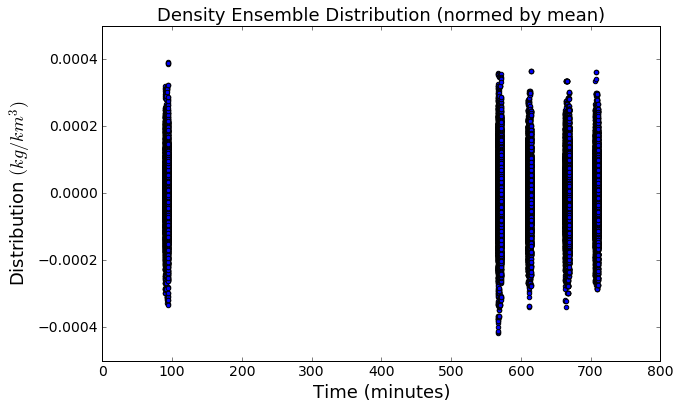

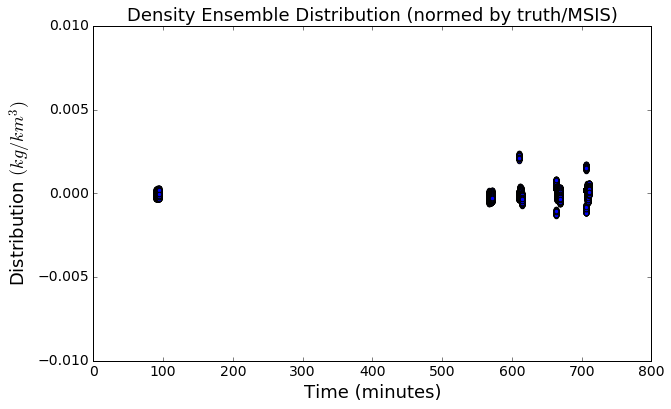

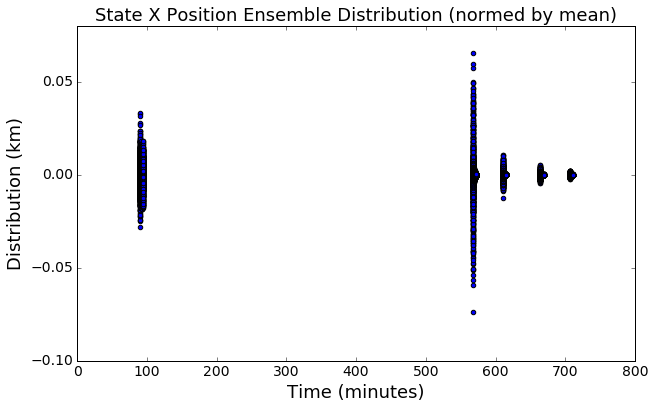

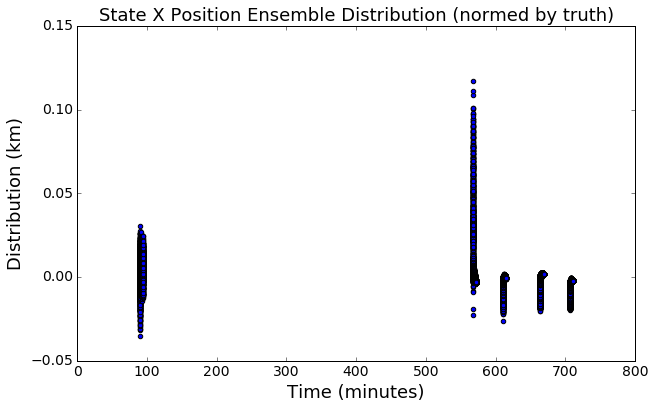

In [55]:

times = measurement_array[:stop_index, 0]/(60)

time_str = 'Time (minutes)'

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_X_ensembles)

#"""
#calculate the normed density distribution by subtracting the mean of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
density_distribution_mean = np.mean(density_distribution[:,:stop_index], axis=0).reshape(1, stop_index)

density_distribution_mean_tiled = np.tile(density_distribution_mean, (1, num_of_X_ensembles))
density_distribution_mean_tiled = density_distribution_mean_tiled.reshape(num_of_X_ensembles, stop_index)

density_distribution_normed = density_distribution[:, :stop_index] - density_distribution_mean_tiled

fig = plt.figure()
plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim(-.5e-3, .5e-3)
plt.title('Density Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()



#calculate the normed density distribution by subtracting the truth of the ensemble from each ensemble   
#density_distribution shape = num_of_ensembles x stop_index
density_distribution_truth = density_MSIS_array[:stop_index].reshape(1, stop_index)
density_distribution_normed = density_distribution[:, :stop_index] - \
                    np.tile(density_distribution_truth, (num_of_ensembles, 1))

fig = plt.figure()
plt.scatter(time_repeated_ensemble, density_distribution_normed.T.flatten())
plt.ylabel(r'Distribution $(kg/km^3)$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim(-1e-2, 1e-2)
plt.title('Density Ensemble Distribution (normed by truth/MSIS)', fontsize=18)
plt.show()
#"""

#calculate the normed X pos distribution by subtracting the mean of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_X_ensembles x stop_index
X_distribution_Xpos = X_distribution[0,:,:stop_index]
X_distribution_Xpos_mean = np.mean(X_distribution_Xpos, axis=0).reshape(1, stop_index)
X_distribution_Xpos_mean_tiled = np.tile(X_distribution_Xpos_mean, (1, num_of_X_ensembles))
X_distribution_Xpos_mean_tiled = X_distribution_Xpos_mean_tiled.reshape(num_of_X_ensembles, stop_index)
X_distribution_Xpos_diff = X_distribution_Xpos - X_distribution_Xpos_mean_tiled

fig = plt.figure()
plt.scatter(time_repeated_X, X_distribution_Xpos_diff.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4,1e-4)
plt.title('State X Position Ensemble Distribution (normed by mean)', fontsize=18)
plt.show()



#calculate the normed X pos distribution by subtracting the truth of the ensemble from each ensemble   
#X_distribution shape = 6 x num_of_X_ensembles x stop_index
X_distribution_Xpos_truth = truth_xyz[:stop_index, 0].reshape(1, stop_index)
X_distribution_Xpos_truth_normed = X_distribution_Xpos - np.tile(X_distribution_Xpos_truth, (num_of_ensembles, 1))

fig = plt.figure()
plt.scatter(time_repeated_ensemble, X_distribution_Xpos_truth_normed.T.flatten())
plt.ylabel(r'Distribution (km)', fontsize=18)
plt.xlabel(time_str, fontsize=18)
#plt.ylim(-1e-4, 1e-4)
plt.title('State X Position Ensemble Distribution (normed by truth)', fontsize=18)
plt.show()



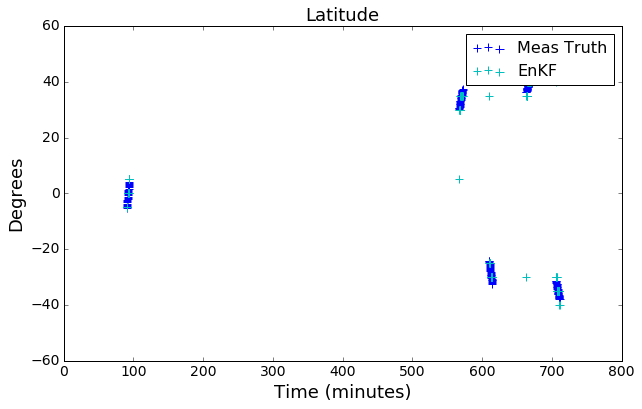

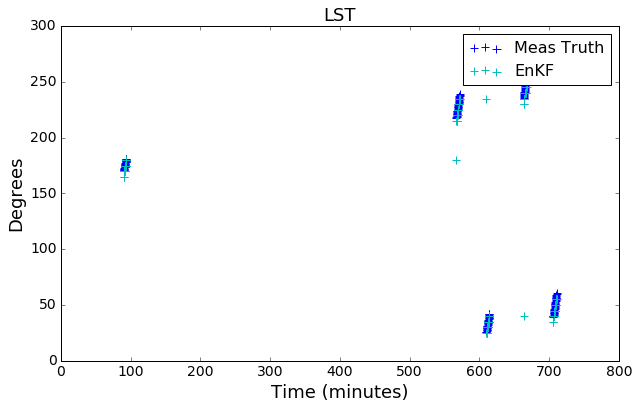

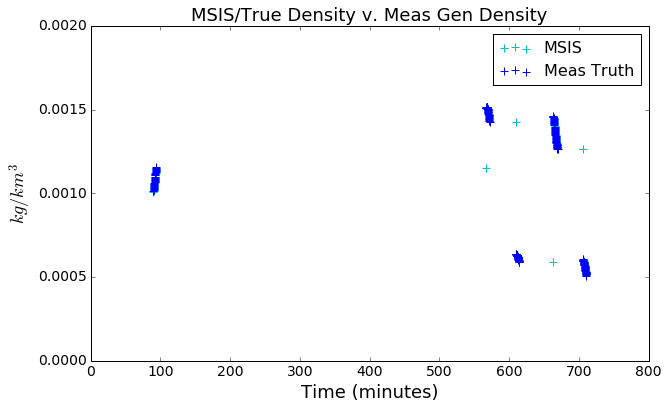

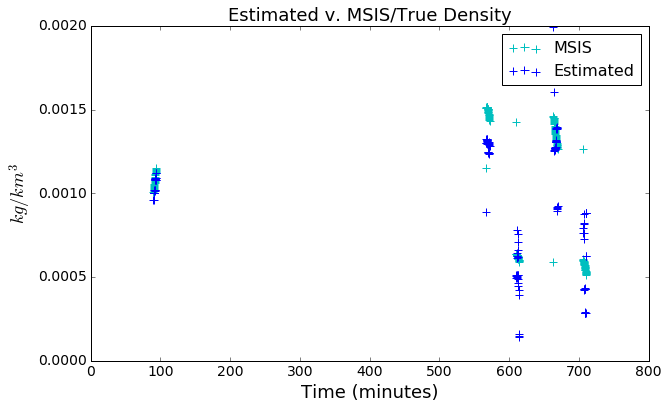

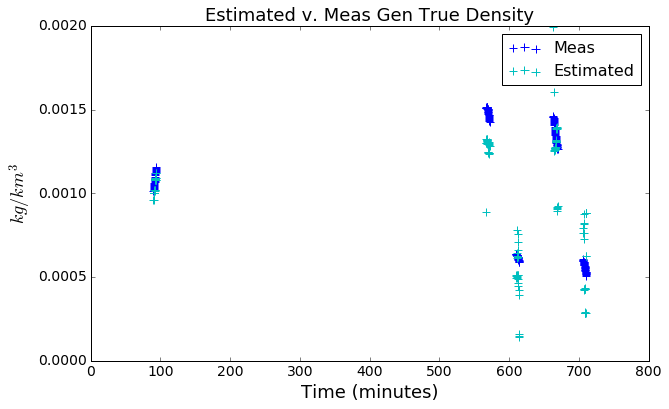

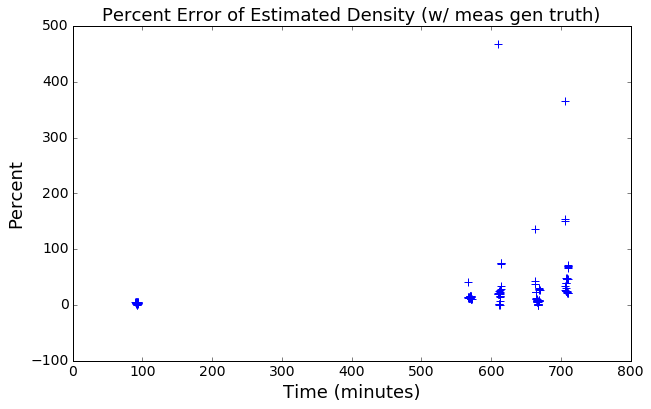

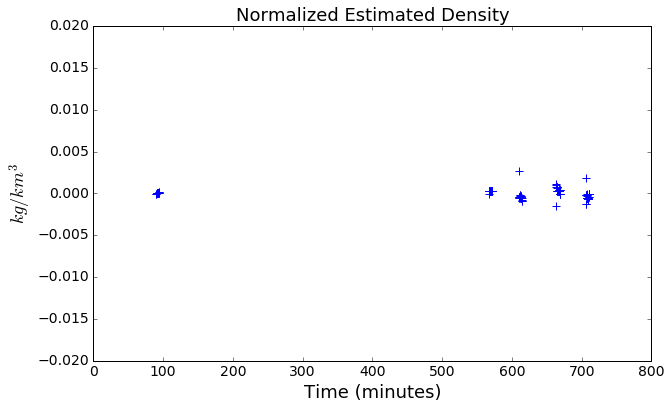

"\nfig_lat.savefig('Figures/latitude.png')\nfig_LST.savefig('Figures/LST.png')\nfig_density_comparison.savefig('Figures/density_comparison.png')\nfig_percent.savefig('Figures/percent.png')\nfig_est.savefig('Figures/est_density.png')\n"

In [56]:
#stop_index = 10


times = measurement_array[:stop_index, 0]/(60)

time_repeated_ensemble = np.repeat(times[:stop_index], num_of_ensembles)
time_repeated_X = np.repeat(times[:stop_index], num_of_X_ensembles)


fig_lat = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 0]), s=70, c='b',marker='+')
plt.scatter(times, np.degrees(lat_lst_array[0,:stop_index]), s=70, c='c',marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Latitude', fontsize=18)
legend_names = ['Meas Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()



fig_LST = plt.figure()
plt.scatter(times, np.degrees(lat_lst_meas_array[:stop_index, 1]), s=70, c='b', marker='+')
plt.scatter(times, np.degrees(lat_lst_array[1,:stop_index]), s=70, c='c', marker='+')
plt.ylabel('Degrees', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('LST', fontsize=18)
legend_names = ['Meas Truth', 'EnKF']
plt.legend(legend_names, fontsize=16)
plt.show()


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='c', marker='+')
plt.scatter(times, true_density_array[:stop_index], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('MSIS/True Density v. Meas Gen Density', fontsize=18)
legend_names = ['MSIS', 'Meas Truth']
plt.legend(legend_names, fontsize=16)
plt.show()


fig_density_comparison = plt.figure()
plt.scatter(times, density_MSIS_array[:stop_index], s=70, c='c', marker='+')
plt.scatter(times, est_density_array[:stop_index], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('Estimated v. MSIS/True Density', fontsize=18)
legend_names = ['MSIS', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()




fig_density_comparison = plt.figure()
plt.scatter(times, true_density_array[:stop_index], s=70, c='b', marker='+')
plt.scatter(times, est_density_array[:stop_index], s=70, c='c', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.ylim([0,2e-3])
plt.title('Estimated v. Meas Gen True Density', fontsize=18)
legend_names = ['Meas', 'Estimated']
plt.legend(legend_names, fontsize=16)
plt.show()


perc_error = 100 * np.absolute(est_density_array[:stop_index] - true_density_array[:stop_index])/true_density_array[:stop_index]

fig_percent = plt.figure()
plt.scatter(times, perc_error[:stop_index], s=70, c='b', marker='+')
#plt.ylim([-1e-11,1e-11])
plt.ylabel('Percent', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Percent Error of Estimated Density (w/ meas gen truth)', fontsize=18)
plt.show()



mean = np.mean(est_density_array[:stop_index])
est_density_array_normalized = est_density_array[:stop_index] - mean

fig_est = plt.figure()
plt.scatter(times, est_density_array_normalized[:stop_index], s=70, c='b', marker='+')
plt.ylabel(r'$kg/km^3$', fontsize=18)
plt.xlabel(time_str, fontsize=18)
plt.title('Normalized Estimated Density', fontsize=18)
plt.show()


"""
fig_lat.savefig('Figures/latitude.png')
fig_LST.savefig('Figures/LST.png')
fig_density_comparison.savefig('Figures/density_comparison.png')
fig_percent.savefig('Figures/percent.png')
fig_est.savefig('Figures/est_density.png')
"""

[]


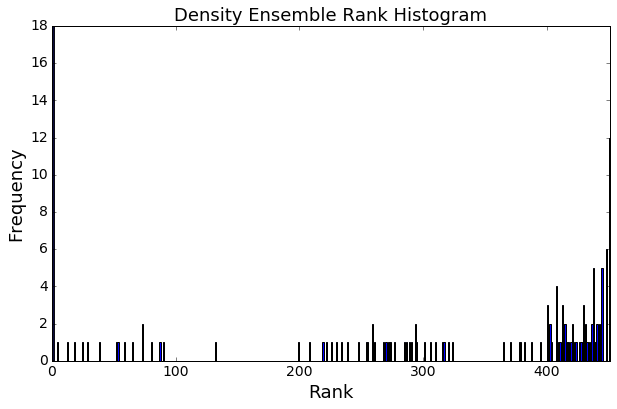

In [57]:
# Rank Histograms


#Density

rank_array = np.zeros((stop_index, 1))

for ii in range(stop_index):
    
    new_array = np.append(density_distribution[:, ii], density_MSIS_array[ii])
    
    rank = scipy.stats.rankdata(new_array, method='min')[-1]
    
    rank_array[ii] = rank
    
indices = np.where(rank_array != 450)[0]
indices1 = np.where(rank_array == 450)[0]
print(times[indices1])


fig_rank_hist = plt.figure()
plt.hist(rank_array, bins=451)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Rank', fontsize=18)
plt.title('Density Ensemble Rank Histogram', fontsize=18)
plt.xlim([0,451])
plt.show()

#fig_rank_hist.savefig('Figures/rank_hist.png')




Post-fit RMS:
Azimuth = 0.0012993450355 degrees
Elevation = 0.00152076314394 degrees
Range = 0.00030561814948 km


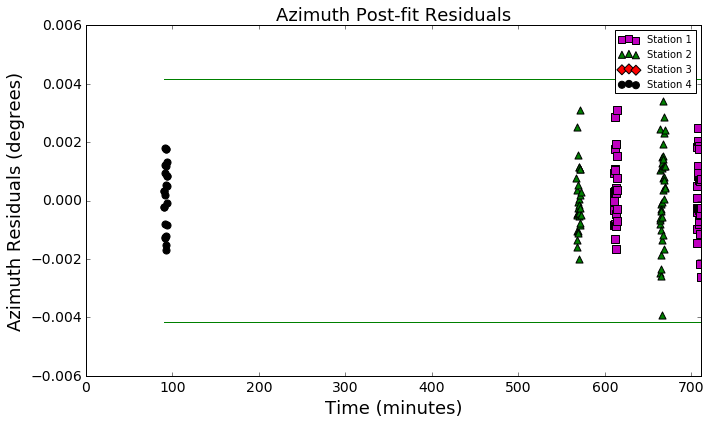

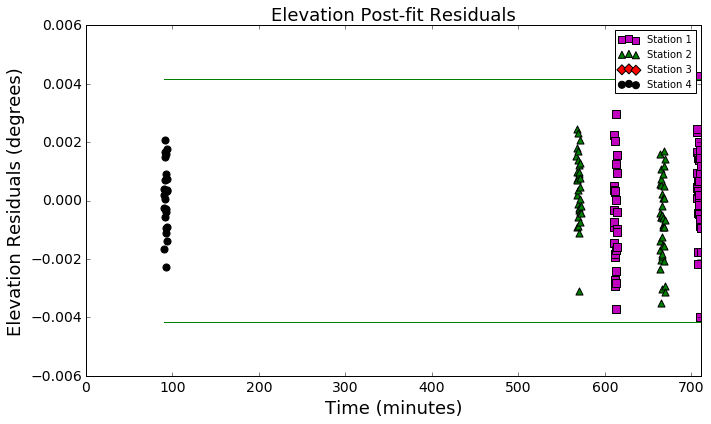

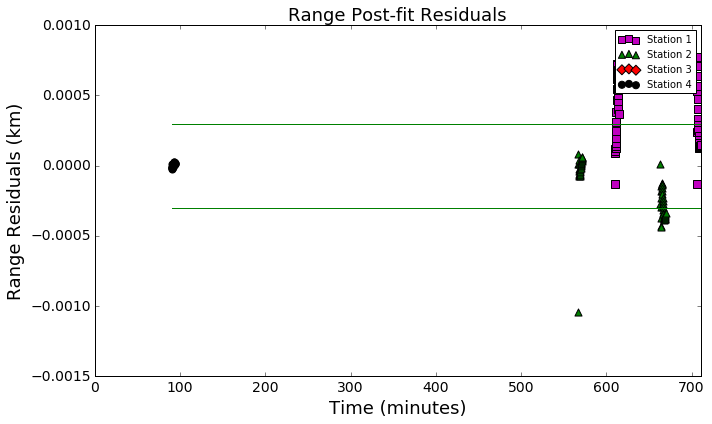

Density RMS = 0.000413854689876 $(kg/km^3)$
Position RMS:
X = 0.00680897444849 km
Y = 0.00745918397729 km
Z = 0.00894012105884 km
Overall = 0.0134880437126 km


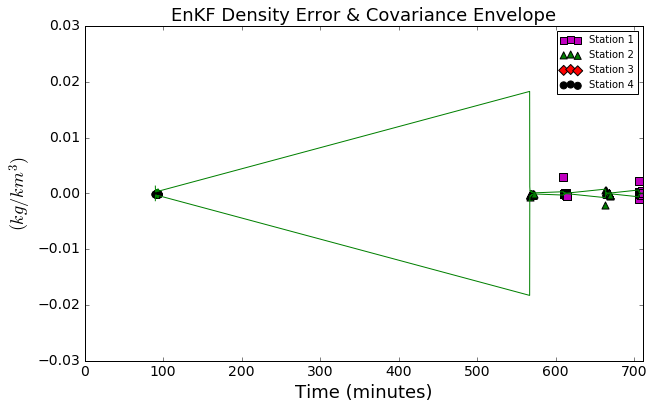

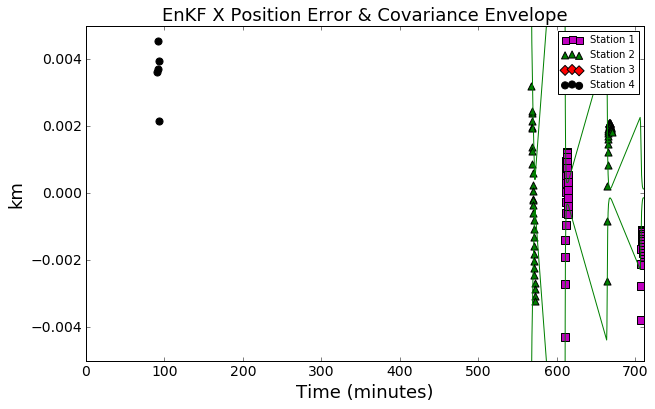

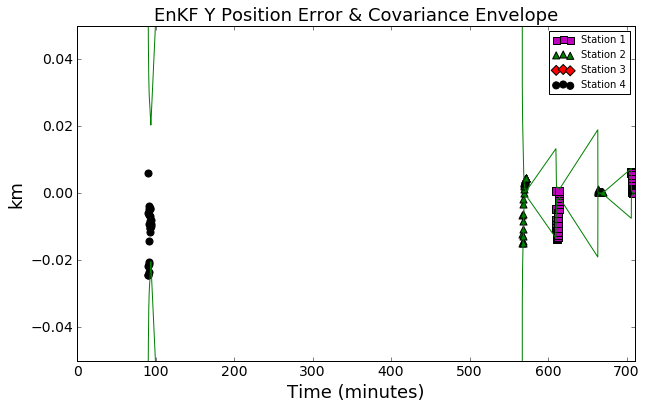

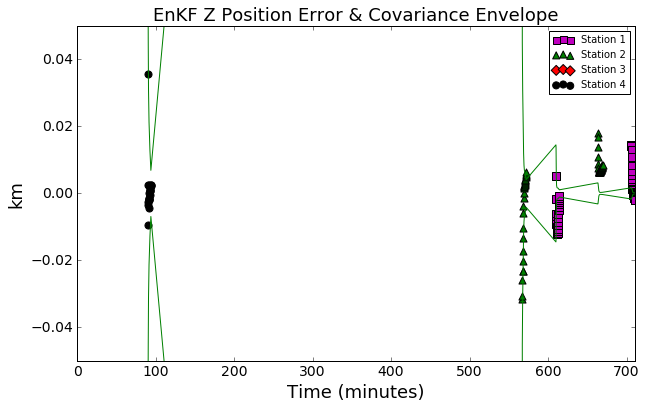

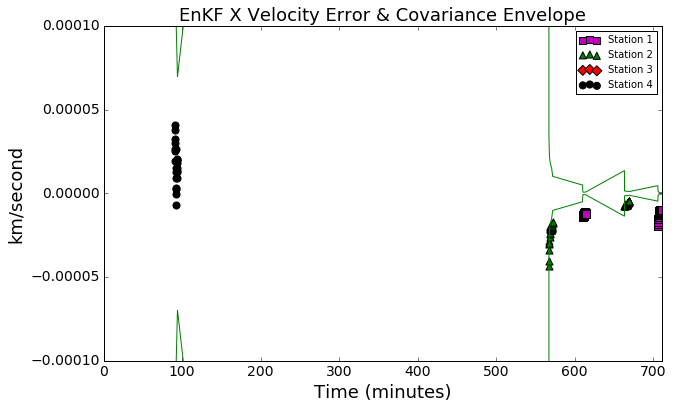

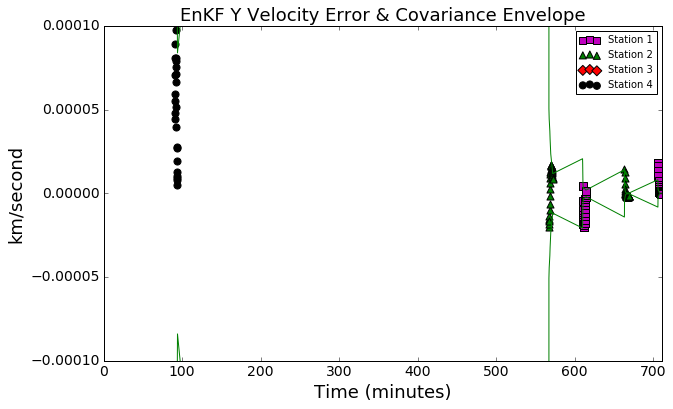

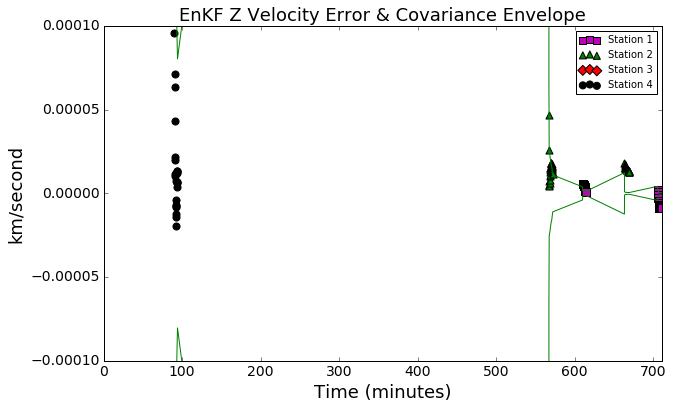

Velocity RMS:
X = 1.81033980323e-05 km/second
Y = 2.60956521803e-05 km/second
Z = 1.66710633032e-05 km/second
Overall = 3.58697704856e-05 km/s


In [58]:

#Generate Plots for Analysis

x_range = .005
y_range = .05
z_range = .05

xv_range = 1e-4
yv_range = 1e-4
zv_range = 1e-4

times = measurement_array[:, 0]

saveFig_bool = False


filter_functions.calc_display_results(post_fit_list_EnKF, measurement_array, R, meas_type, stop_index, saveFig_bool,\
                                     time_str)


filter_functions.plot_error_covar_xref(P_list_EnKF, X_mean_updated_list_EnKF, \
                      truth_xyz, true_density_array, x_range, y_range, z_range, xv_range, yv_range, zv_range,\
                      measurement_array, times, stop_index, saveFig_bool, time_str)


In [59]:
indices = np.where(measurement_array[:, 1] == 1)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 2)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 3)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 4)[0]
print(indices)

[ 55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355
 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 383 384 385 386 387]
[ 24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 158 1